Xshape: torch.Size([300, 1]) 
 Yshape: torch.Size([300, 1])


/local_scratch/slurm.680588/ipykernel_1662029/3457197851.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


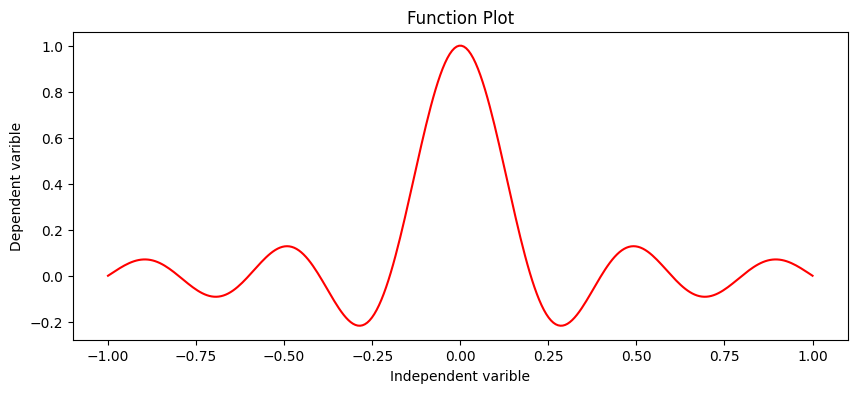

In [35]:
#Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math

#1st Function
#Creating the data

torch.manual_seed(1) 
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)  # x data (tensor), shape=(300, 1)
y = (np.sin(5*np.pi*x))/(5*np.pi*x) #non-linear y function
#y = (np.cos(7 * x * np.pi))
print('Xshape:',x.shape,"\n Yshape:",y.shape)

#x, y = Variable(x), Variable(y) #converting data into variables as pytorch requirments
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

plt.figure(figsize=(10,4))
plt.plot(x, y, color = "red")
plt.title('Function Plot')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig('funcplt.png')

plt.show()

n_samples, n_features = x.shape

In [36]:
class M1(torch.nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 5)   # hidden layer
        self.hidden2 = torch.nn.Linear(5, 10)
        self.hidden3 = torch.nn.Linear (10, 10)
        self.hidden4 = torch.nn.Linear (10, 10)
        self.hidden5 = torch.nn.Linear (10, 10)
        self.hidden6 = torch.nn.Linear (10, 10)
        self.hidden7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1)   # output layer
        #self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      # activation function for hidden layer
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)                    # linear output
        return x

m1 = M1()     # define the network
#optimizer = torch.optim.RMSprop(m1.parameters(), lr=0.0012, weight_decay = 1e-4)
optimizer = torch.optim.Adam(m1.parameters(), lr=0.0012, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

a=[]
for i in m1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

#Getting weights & bias
print("\nModel 1 weight and bias before training\n")
for param in m1.state_dict():
    print(param, "\t",m1.state_dict()[param])

Total no of parameters in Model 1: 571

Model 1 weight and bias before training

hidden1.weight 	 tensor([[ 0.5153],
        [-0.4414],
        [-0.1939],
        [ 0.4694],
        [-0.9414]])
hidden1.bias 	 tensor([ 0.5997, -0.2057,  0.5087,  0.1390, -0.1224])
hidden2.weight 	 tensor([[ 0.1240,  0.0221,  0.1633, -0.1743, -0.0326],
        [-0.0403,  0.0648, -0.0018,  0.3909,  0.1392],
        [-0.1665, -0.2701, -0.0750, -0.1929, -0.1433],
        [ 0.0214,  0.2666,  0.2431, -0.4372,  0.2772],
        [ 0.1249,  0.4242,  0.2952, -0.4075, -0.4252],
        [-0.2157,  0.3927, -0.0745,  0.1914, -0.2078],
        [ 0.4388, -0.1892,  0.3354,  0.0053, -0.2356],
        [ 0.2299, -0.2374,  0.1315, -0.1291, -0.0490],
        [-0.4299, -0.2132,  0.2427, -0.1087,  0.4454],
        [ 0.3585, -0.0209, -0.2985,  0.2723,  0.1388]])
hidden2.bias 	 tensor([-0.2891,  0.2905,  0.2715,  0.3966, -0.2507, -0.0736, -0.0087,  0.0653,
        -0.3394, -0.3174])
hidden3.weight 	 tensor([[ 0.1720, -0.0742,  0.

In [37]:
def trainFunc(model,x,y):
    model.train()
    max_epoch = 25000
    epoch_arr,loss_arr=[],[]
    not_converged = True
    epoch = 0
    while not_converged:
        epoch += 1
        prediction = model(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step() 
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())
        
        if epoch%100 == 0 : print(f'epoch: {epoch}, loss = {loss.item():.4f}', end='\r', flush= True) #, weight = {model.weight.item()},  bias ={model.bias.item()}')
                
        if epoch == max_epoch:
                print("Max Epoch Reached")
                not_converged = False
        elif (epoch > 5) and  (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-05 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-05:
                print(f"Convergeance reached for loss:{loss_arr[-1]:.4f} at epoch: {epoch}")
                not_converged = False
                
    return epoch_arr,loss_arr,prediction

In [38]:
M1epoch_arr,M1loss_arr,M1prediction = trainFunc(m1,x,y)

Convergeance reached for loss:0.0007 at epoch: 760


In [39]:
#Getting weights & bias
print("\nModel 1 weight and bias after training\n")
for param in m1.state_dict():
    print(param, "\t",m1.state_dict()[param])


Model 1 weight and bias after training

hidden1.weight 	 tensor([[ 0.3996],
        [-0.4621],
        [-0.2745],
        [ 0.5821],
        [-0.9040]])
hidden1.bias 	 tensor([0.3340, 0.0103, 0.1854, 0.0095, 0.0038])
hidden2.weight 	 tensor([[-5.9036e-07,  2.5715e-07, -2.2058e-07,  8.9882e-07,  6.7727e-07],
        [ 1.7981e-01,  4.1170e-01, -2.1914e-01,  5.4188e-01,  5.4797e-01],
        [ 1.6180e-01,  1.1733e-01, -2.0212e-01,  3.4215e-01,  2.6230e-01],
        [ 1.4144e-01,  2.8162e-01, -2.1183e-01,  1.9802e-01,  5.1820e-01],
        [-5.2719e-06,  7.7479e-03,  2.2842e-04, -5.8322e-03, -7.9170e-03],
        [-1.3551e-01,  1.7848e-01,  8.7096e-02,  2.9262e-03,  2.3109e-01],
        [ 2.9332e-01,  1.8228e-01, -1.5027e-01,  4.2264e-01,  2.2686e-01],
        [ 2.0173e-01,  2.2989e-01, -2.0509e-01,  4.7584e-01,  4.7755e-01],
        [-1.4086e-01,  1.7339e-01,  2.1380e-01, -7.3266e-02,  3.1418e-01],
        [ 1.9049e-02, -1.8359e-06, -2.4395e-03,  1.4325e-02,  4.8045e-06]])
hidden2.bias 	

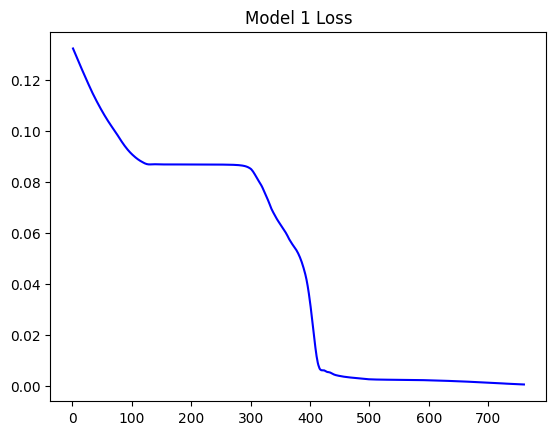

In [40]:
#plot
plt.plot(M1epoch_arr,M1loss_arr,color="blue")
plt.title('Model 1 Loss')
plt.show()

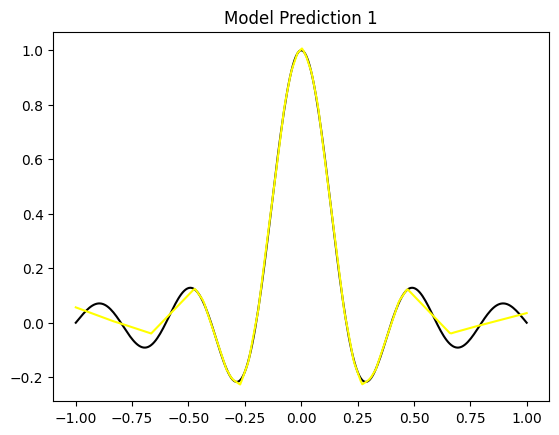

In [41]:
#plot

plt.plot(x.numpy(),y.numpy(),color="black")
plt.plot(x,M1prediction.data.numpy(),color="yellow")
plt.title('Model Prediction 1')
plt.show()

In [42]:
class M2(torch.nn.Module):
    def __init__(self,):
        super(M2, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 10)   # hidden layer
        self.hidden2 = torch.nn.Linear (10, 18)
        self.hidden3 = torch.nn.Linear (18, 15)
        self.hidden4 = torch.nn.Linear (15, 4)
        self.predict = torch.nn.Linear(4, 1)   # output layer
        #self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      # activation function for hidden layer
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = self.predict(x)                    # linear output
        return x

m2 = M2()     # define the network
#optimizer = torch.optim.RMSprop(m1.parameters(), lr=0.0012, weight_decay = 1e-4)
optimizer = torch.optim.Adam(m2.parameters(), lr=0.0012, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

a=[]
for i in m2.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 2:', np.sum(a))


#Getting weights & bias
print("\nModel 2 weight and bias before training\n")
for param in m2.state_dict():
    print(param, "\t",m2.state_dict()[param])

Total no of parameters in Model 2: 572

Model 2 weight and bias before training

hidden1.weight 	 tensor([[-0.1516],
        [-0.8101],
        [-0.7396],
        [-0.2935],
        [-0.2215],
        [ 0.1141],
        [-0.2243],
        [ 0.3690],
        [-0.3326],
        [ 0.7340]])
hidden1.bias 	 tensor([ 0.2297, -0.3074,  0.8912,  0.2553, -0.6796, -0.5565,  0.6270,  0.4567,
         0.7808, -0.0768])
hidden2.weight 	 tensor([[ 0.2212,  0.1572,  0.0978, -0.0732,  0.3048,  0.0640, -0.0816, -0.0045,
          0.3109,  0.2124],
        [-0.0234,  0.3100,  0.1389, -0.1684, -0.2878,  0.1838,  0.2966, -0.1842,
          0.1299,  0.0135],
        [-0.0676, -0.0860,  0.0880,  0.0697,  0.2136,  0.1158,  0.1439,  0.2790,
          0.0985,  0.0469],
        [-0.1151,  0.2319,  0.0467,  0.2038,  0.3054, -0.0707,  0.2227, -0.0642,
          0.2854,  0.2489],
        [-0.1133,  0.0113, -0.1381, -0.1279, -0.0640, -0.0022, -0.1102, -0.2985,
         -0.1913, -0.0270],
        [-0.1009,  0.2349, 

In [43]:
M2epoch_arr,M2loss_arr,M2prediction = trainFunc(m2,x,y)

Convergeance reached for loss:0.0010 at epoch: 862


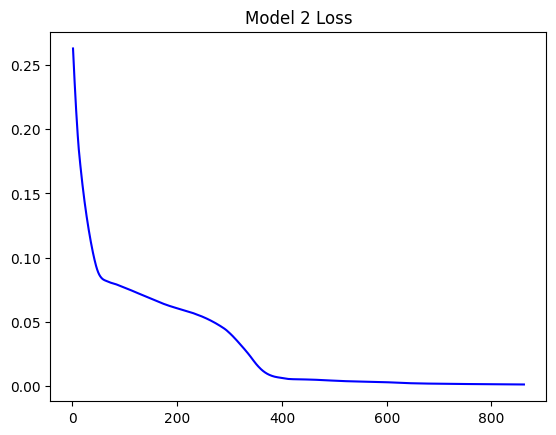

In [44]:
#plot
plt.plot(M2epoch_arr,M2loss_arr,color="blue")
plt.title('Model 2 Loss')
plt.show()

In [45]:
#Getting weights & bias
print("\nModel 2 weight and bias after training\n")
for param in m2.state_dict():
    print(param, "\t",m2.state_dict()[param])


Model 2 weight and bias after training

hidden1.weight 	 tensor([[-2.4020e-01],
        [-1.3578e+00],
        [-1.1285e+00],
        [-7.8485e-01],
        [-2.9027e-05],
        [-1.2430e-04],
        [-4.4812e-01],
        [ 9.5000e-01],
        [-4.1666e-01],
        [ 1.1676e+00]])
hidden1.bias 	 tensor([ 0.2115, -0.0221,  0.7714,  0.1551, -0.1006, -0.0455,  0.5476,  0.4625,
         0.7265,  0.0051])
hidden2.weight 	 tensor([[ 1.3292e-01,  2.6334e-02,  1.7593e-02, -3.1096e-01,  2.0331e-02,
          6.4930e-04, -1.3377e-01,  8.1057e-02,  2.4988e-01,  4.1067e-01],
        [ 3.9149e-02,  7.2187e-01,  2.1242e-01, -3.7861e-03, -2.6038e-03,
          3.5794e-03,  3.4000e-01, -4.5575e-01,  1.7217e-01, -2.7678e-03],
        [-8.5870e-03, -1.0625e-02,  1.4426e-01,  1.0203e-01,  5.9577e-03,
          2.9681e-04,  1.9363e-01,  3.1785e-01,  1.5261e-01,  1.0990e-01],
        [-1.3823e-01,  1.9294e-02, -9.5555e-03,  1.0542e-01,  4.0861e-03,
         -2.9293e-05,  1.7182e-01, -6.8809e-02,  2.

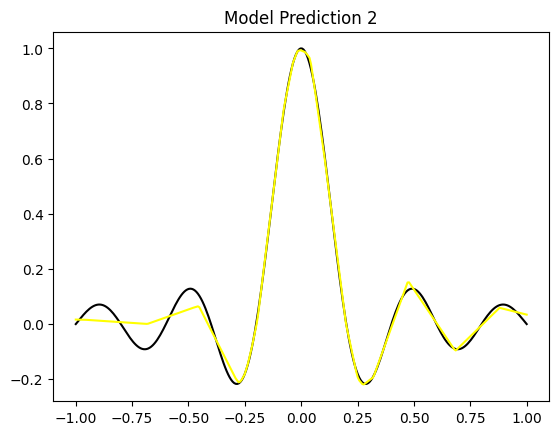

In [46]:
#plot
plt.plot(x.numpy(),y.numpy(),color="black")
plt.plot(x,M2prediction.data.numpy(),color="yellow")
plt.title('Model Prediction 2')
plt.show()

In [47]:
class M3(torch.nn.Module):
    def __init__(self,):
        super(M3, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 190)   # hidden layer
        self.predict = torch.nn.Linear(190, 1)   # output layer
        #self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      # activation function for hidden layer
        x = self.predict(x)                    # linear output
        return x

m3 = M3()     # define the network
#optimizer = torch.optim.RMSprop(m1.parameters(), lr=0.0012, weight_decay = 1e-4)
optimizer = torch.optim.Adam(m3.parameters(), lr=0.0011, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

a=[]
for i in m3.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(a))


#Getting weights & bias
print("\nModel 3 weight and bias before training\n")
for param in m3.state_dict():
    print(param, "\t",m3.state_dict()[param])

Total no of parameters in Model 3: 571

Model 3 weight and bias before training

hidden1.weight 	 tensor([[-0.0454],
        [ 0.1646],
        [-0.2346],
        [-0.6331],
        [-0.4523],
        [-0.0664],
        [-0.8181],
        [-0.8082],
        [ 0.1097],
        [-0.6507],
        [-0.5439],
        [-0.0086],
        [-0.5270],
        [ 0.9256],
        [-0.3610],
        [-0.5560],
        [-0.2664],
        [-0.8159],
        [ 0.5152],
        [ 0.8592],
        [-0.5767],
        [-0.3717],
        [ 0.9333],
        [-0.7234],
        [ 0.2708],
        [-0.8148],
        [-0.8900],
        [ 0.0015],
        [-0.5707],
        [ 0.5416],
        [-0.3093],
        [ 0.0099],
        [-0.5221],
        [ 0.4109],
        [ 0.9265],
        [-0.1503],
        [-0.6172],
        [-0.9753],
        [ 0.9583],
        [ 0.4215],
        [ 0.4130],
        [ 0.1703],
        [ 0.5018],
        [ 0.3551],
        [ 0.4883],
        [ 0.6254],
        [ 0.1418],
        [

In [48]:
M3epoch_arr,M3loss_arr,M3prediction = trainFunc(m3,x,y)

Convergeance reached for loss:0.0010 at epoch: 2183


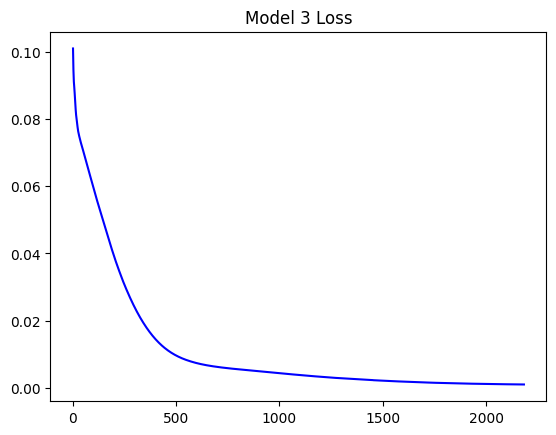

In [49]:
#plot
plt.plot(M3epoch_arr,M3loss_arr,color="blue")
plt.title('Model 3 Loss')
plt.show()

In [50]:
#Getting weights & bias
print("\nModel 3 weight and bias before training\n")
for param in m3.state_dict():
    print(param, "\t",m3.state_dict()[param])


Model 3 weight and bias before training

hidden1.weight 	 tensor([[-2.2525e-03],
        [ 1.5112e-10],
        [-6.2506e-02],
        [-5.1144e-01],
        [-7.6834e-01],
        [ 3.3816e-08],
        [-1.0283e+00],
        [-1.3181e+00],
        [-2.5575e-03],
        [-1.5322e-05],
        [-6.4222e-01],
        [ 3.8215e-11],
        [-1.3241e-07],
        [ 9.0182e-01],
        [-9.6539e-01],
        [-3.9920e-01],
        [-5.8729e-01],
        [-3.6684e-01],
        [ 1.1650e+00],
        [ 1.8536e-01],
        [-1.0179e+00],
        [-8.3615e-02],
        [ 4.0844e-01],
        [-1.0008e-04],
        [ 6.0282e-02],
        [-6.8126e-01],
        [-5.8178e-01],
        [ 2.3703e-03],
        [-1.0782e-01],
        [ 2.3070e-02],
        [-1.1717e-02],
        [ 9.4449e-04],
        [-8.6992e-01],
        [ 1.5823e-03],
        [ 5.6403e-01],
        [-4.0710e-02],
        [-1.0582e+00],
        [-1.5752e+00],
        [ 1.2708e+00],
        [ 3.2202e-09],
        [ 2.5773e-01]

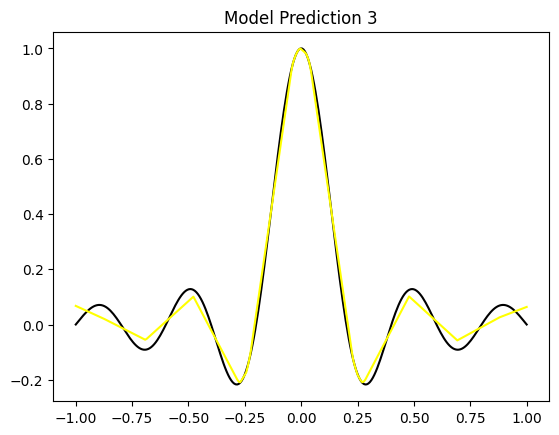

In [51]:
#plot
plt.plot(x.numpy(),y.numpy(),color="black")
plt.plot(x,M3prediction.data.numpy(),color="yellow")
plt.title('Model Prediction 3')
plt.show()

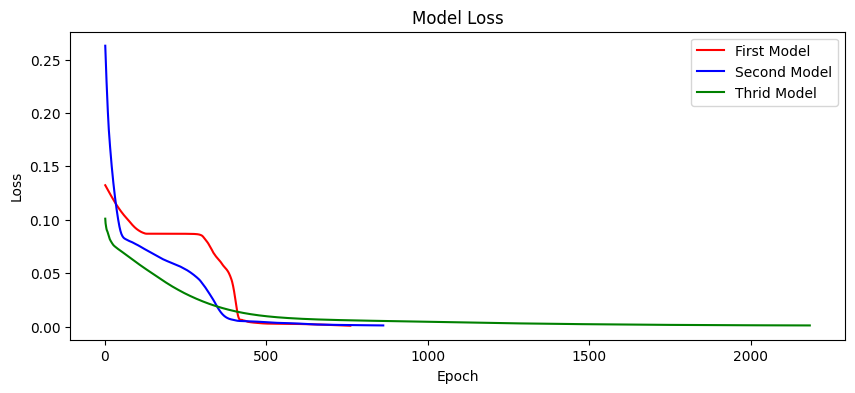

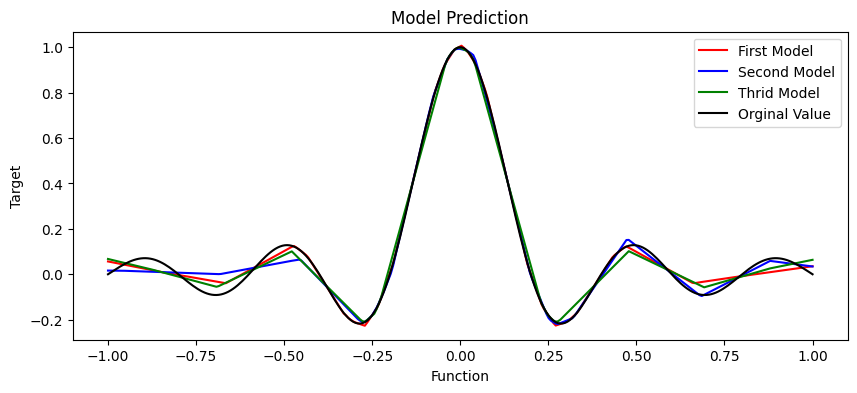

In [52]:
plt.figure(figsize=(10,4))
plt.plot(M1epoch_arr,M1loss_arr, color = "red")
plt.plot(M2epoch_arr,M2loss_arr, color = "blue")
plt.plot(M3epoch_arr,M3loss_arr, color = "green")
plt.title('Model Loss')
plt.legend(['First Model', 'Second Model','Thrid Model'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('EpochVSLoss.png')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x,M1prediction.data.numpy(),color="red")
plt.plot(x,M2prediction.data.numpy(),color="blue")
plt.plot(x,M3prediction.data.numpy(),color="green")
plt.plot(x,y.numpy(),color="black")
plt.title('Model Prediction')
plt.legend(['First Model', 'Second Model','Thrid Model','Orginal Value'])
plt.xlabel('Function')
plt.ylabel('Target')
plt.savefig('Model_Prediction.png')
plt.show()

Xshape: torch.Size([300, 1]) 
 Yshape: torch.Size([300, 1])


/local_scratch/slurm.680588/ipykernel_1662029/3631774031.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2, y2 = torch.tensor(x2, dtype=torch.float32), torch.tensor(y2, dtype=torch.float32)


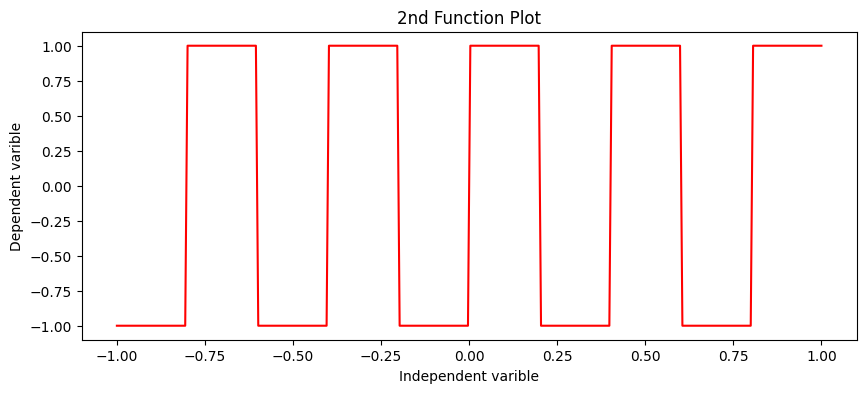

In [53]:
#2nd Function
#Creating the data

torch.manual_seed(1) 
x2 = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)  # x data (tensor), shape=(300, 1)
y2 = np.sign(np.sin(5*np.pi*x)) #non-linear y function
#y = (np.cos(7 * x * np.pi))

print('Xshape:',x.shape,"\n Yshape:",y.shape)

#x, y = Variable(x), Variable(y) #converting data into variables as pytorch requirments
x2, y2 = torch.tensor(x2, dtype=torch.float32), torch.tensor(y2, dtype=torch.float32)

plt.figure(figsize=(10,4))
plt.plot(x2, y2, color = "red")
plt.title('2nd Function Plot')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig('funcplt.png')

plt.show()

n_samples, n_features = x2.shape

In [54]:
f2m1 = M1()     # re-initialize the network
optimizer = torch.optim.Adam(f2m1.parameters(), lr=0.009, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

F2M1epoch_arr,F2M1loss_arr,F2M1prediction = trainFunc(f2m1,x2,y2)

Convergeance reached for loss:0.0010 at epoch: 16621


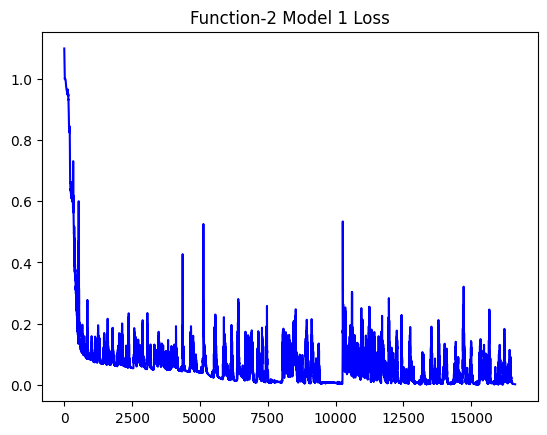

In [55]:
#plot
plt.plot(F2M1epoch_arr,F2M1loss_arr,color="blue")
plt.title('Function-2 Model 1 Loss')
plt.show()

In [56]:
#Getting weights & bias
print("\nModel 1 weight and bias after training for F2\n")
for param in f2m1.state_dict():
    print(param, "\t",f2m1.state_dict()[param])


Model 1 weight and bias after training for F2

hidden1.weight 	 tensor([[-0.1936],
        [-0.9887],
        [-0.7395],
        [ 2.1767],
        [-2.1885]])
hidden1.bias 	 tensor([ 0.3524,  0.4184,  0.3104, -0.4192,  0.0350])
hidden2.weight 	 tensor([[-2.2896e-02, -1.0893e-03,  1.5882e-03,  2.9048e-02,  7.4022e-03],
        [-2.4862e-01,  1.7081e-01, -1.1858e-02, -2.2310e-01,  2.0842e-01],
        [-5.0424e-01, -7.2878e-02, -4.5335e-02,  1.6177e-02,  5.1091e-01],
        [ 3.9210e-01,  6.0409e-01,  4.4901e-01, -4.7811e-01,  9.5546e-01],
        [-2.6748e-03,  9.4476e-01,  7.1561e-01, -3.0299e+00, -1.1917e+00],
        [-3.2874e-01,  7.1144e-01,  5.8854e-01, -6.2150e-01,  1.3723e+00],
        [ 4.0052e-01,  3.8162e-01,  2.7587e-01, -1.1037e+00,  1.7741e-01],
        [-2.7979e-01,  6.3351e-02,  1.1639e-01, -3.1039e-02,  6.9538e-01],
        [-4.5818e-01,  1.4203e-01, -1.2285e-01, -3.8938e-02,  1.0120e+00],
        [ 3.4380e-01,  1.0125e-01,  3.1238e-01,  7.2160e-01, -5.5493e-01]])
hi

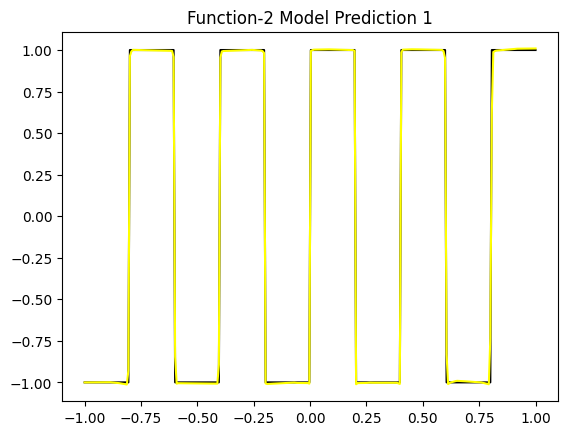

In [57]:
#plot
plt.plot(x2.numpy(),y2.numpy(),color="black")
plt.plot(x2,F2M1prediction.data.numpy(),color="yellow")
plt.title('Function-2 Model Prediction 1')
plt.show()

In [58]:
f2m2 = M2()     # re-initialize the network
optimizer = torch.optim.Adam(f2m2.parameters(), lr=0.009, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

F2M2epoch_arr,F2M2loss_arr,F2M2prediction = trainFunc(f2m2,x2,y2)

Max Epoch Reacheds = 0.0038


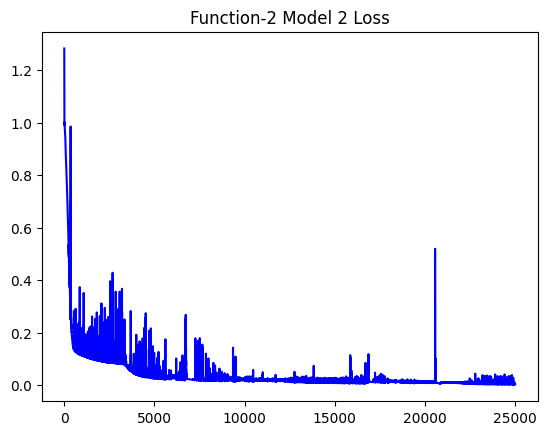

In [59]:
#plot
plt.plot(F2M2epoch_arr,F2M2loss_arr,color="blue")
plt.title('Function-2 Model 2 Loss')
plt.show()

In [60]:
#Getting weights & bias
print("\nModel 2 weight and bias after training for F2\n")
for param in f2m2.state_dict():
    print(param, "\t",f2m2.state_dict()[param])


Model 2 weight and bias after training for F2

hidden1.weight 	 tensor([[-1.5361e+00],
        [-2.6220e+00],
        [-1.0723e+00],
        [-3.0640e-01],
        [-9.9855e-01],
        [-1.3133e-05],
        [-6.7531e-01],
        [ 8.4730e-01],
        [-3.2314e-02],
        [ 1.7127e+00]])
hidden1.bias 	 tensor([ 6.2159e-01, -3.2849e-01,  8.6456e-01,  2.4772e-01, -7.2917e-01,
        -2.3940e-05,  4.0885e-01,  6.8322e-01, -5.4112e-02, -1.0013e+00])
hidden2.weight 	 tensor([[-3.4240e-01,  1.5817e+00, -1.3739e-01, -1.9456e-01, -6.0006e+00,
          1.0543e-05, -2.6021e-01,  7.3212e-01, -3.4447e-02, -3.0859e-01],
        [-3.9597e-03,  2.3284e-03,  1.8687e-02,  2.0763e-03, -8.0283e-04,
          1.1290e-09,  9.5038e-03,  7.6625e-02, -1.0976e-07, -4.8445e-04],
        [-3.9786e-03, -5.0446e-03, -3.1619e-03,  1.8948e-05,  4.6017e-05,
          8.9909e-11, -1.5015e-03,  4.6069e-04,  6.9852e-07, -7.7762e-05],
        [-1.9506e-01, -5.6992e-01,  3.3370e-01,  2.4220e-01,  1.8127e-02,
    

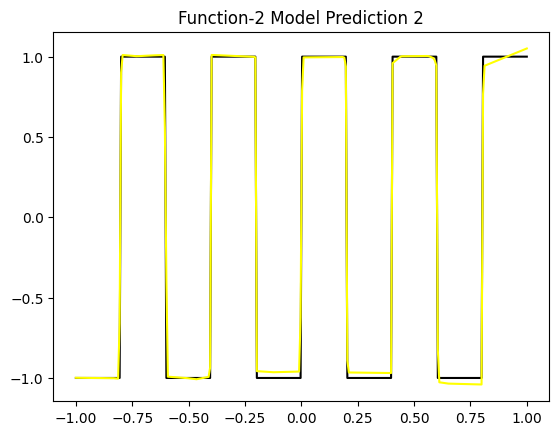

In [61]:
#plot
plt.plot(x2.numpy(),y2.numpy(),color="black")
plt.plot(x2,F2M2prediction.data.numpy(),color="yellow")
plt.title('Function-2 Model Prediction 2')
plt.show()

In [62]:
f2m3 = M3()     # re-initialize the network
optimizer = torch.optim.Adam(f2m3.parameters(), lr=0.009, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
F2M3epoch_arr,F2M3loss_arr,F2M3prediction = trainFunc(f2m3,x2,y2)

Max Epoch Reacheds = 0.0898


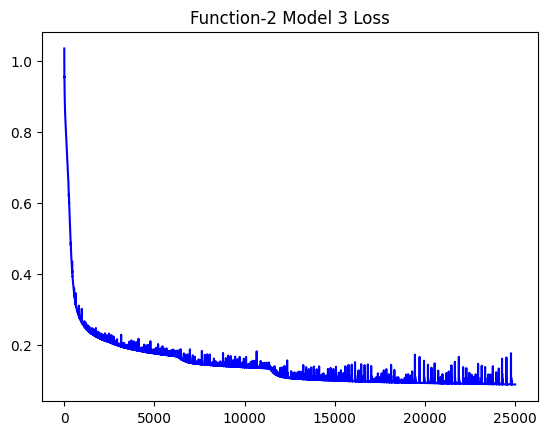

In [63]:
#plot
plt.plot(F2M3epoch_arr,F2M3loss_arr,color="blue")
plt.title('Function-2 Model 3 Loss')
plt.show()

In [64]:
#Getting weights & bias
print("\nModel 3 weight and bias after training for F2\n")
for param in f2m3.state_dict():
    print(param, "\t",f2m3.state_dict()[param])


Model 3 weight and bias after training for F2

hidden1.weight 	 tensor([[-2.0695e-10],
        [ 1.7676e+00],
        [-5.4686e-21],
        [-1.9653e+00],
        [-1.4268e+00],
        [-1.3762e+00],
        [-2.0678e+00],
        [-1.8715e+00],
        [-1.0669e-03],
        [-1.8374e-19],
        [-2.1982e+00],
        [-3.9555e-05],
        [-1.9826e+00],
        [ 1.8396e+00],
        [-2.0506e+00],
        [-2.1102e+00],
        [-4.4888e-01],
        [-5.6402e-01],
        [ 1.5628e+00],
        [ 1.7468e+00],
        [-2.1603e+00],
        [-2.6585e-18],
        [ 2.3388e+00],
        [ 7.2390e-12],
        [ 8.4225e-08],
        [-2.2507e+00],
        [-2.2543e+00],
        [-6.0349e-26],
        [ 4.3612e-40],
        [ 1.5552e+00],
        [-8.7445e-14],
        [-1.1098e-05],
        [-2.2074e+00],
        [-7.2369e-15],
        [ 3.7303e+00],
        [-5.1571e-06],
        [-2.0053e+00],
        [-1.9540e+00],
        [ 2.8371e+00],
        [-2.0640e+00],
        [ 2.054

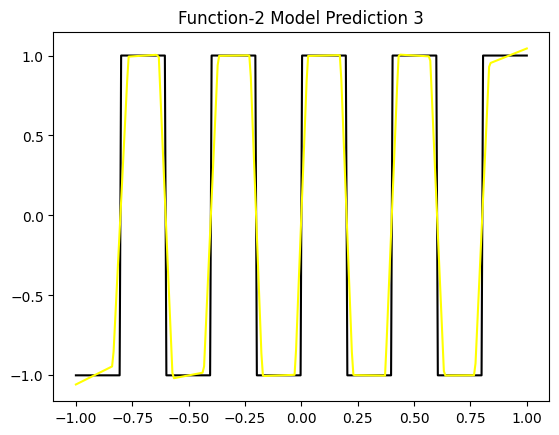

In [65]:
#plot
plt.plot(x2.numpy(),y2.numpy(),color="black")
plt.plot(x2,F2M3prediction.data.numpy(),color="yellow")
plt.title('Function-2 Model Prediction 3')
plt.show()

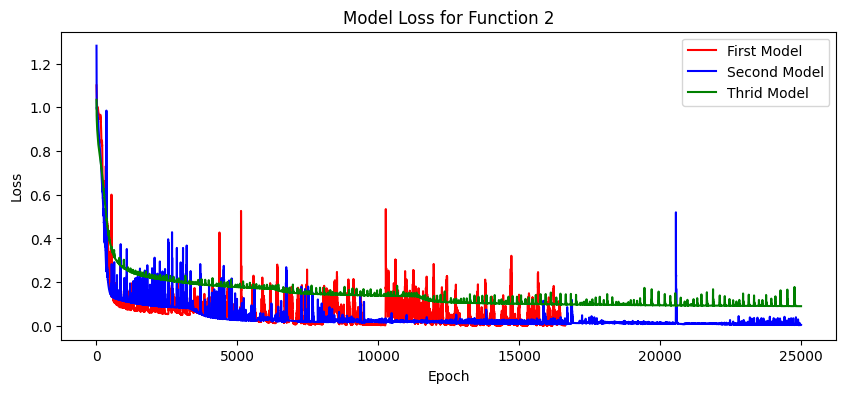

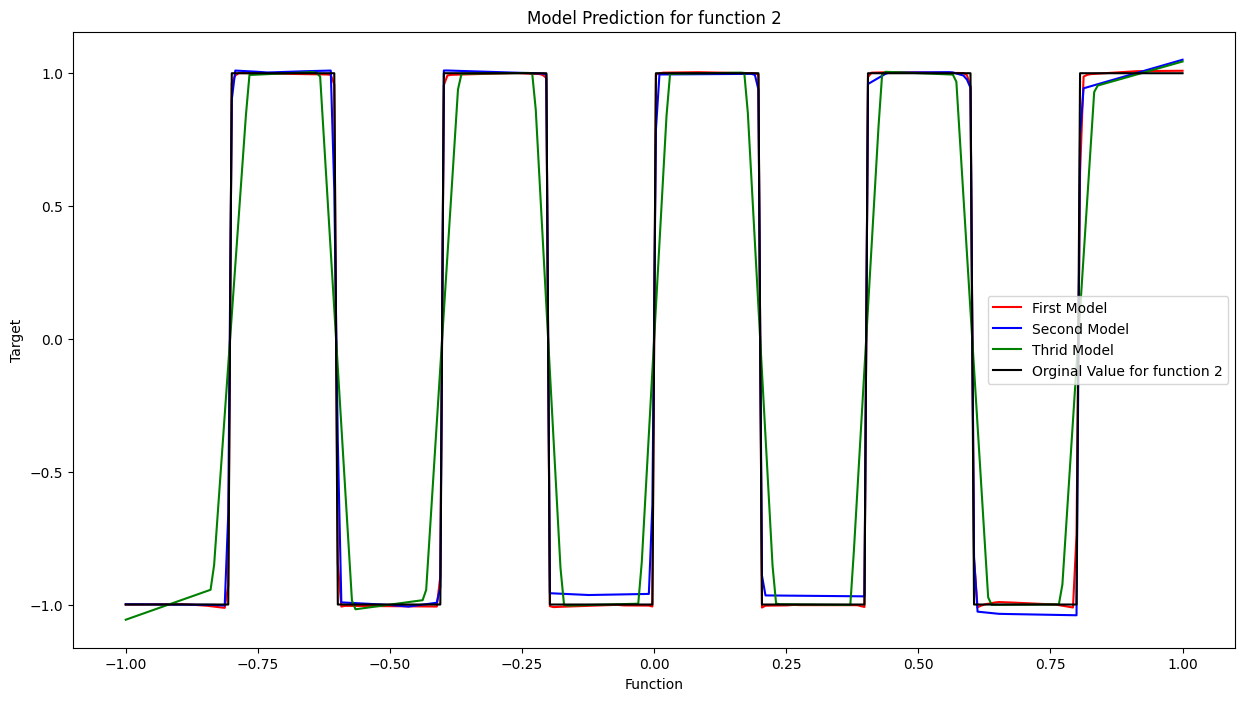

In [66]:
plt.figure(figsize=(10,4))
plt.plot(F2M1epoch_arr,F2M1loss_arr, color = "red")
plt.plot(F2M2epoch_arr,F2M2loss_arr, color = "blue")
plt.plot(F2M3epoch_arr,F2M3loss_arr, color = "green")
plt.title('Model Loss for Function 2')
plt.legend(['First Model', 'Second Model','Thrid Model'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('EpochVSLoss.png')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(x2,F2M1prediction.data.numpy(),color="red")
plt.plot(x2,F2M2prediction.data.numpy(),color="blue")
plt.plot(x2,F2M3prediction.data.numpy(),color="green")
plt.plot(x2,y2.numpy(),color="black")
plt.title('Model Prediction for function 2')
plt.legend(['First Model', 'Second Model','Thrid Model','Orginal Value for function 2'])
plt.xlabel('Function')
plt.ylabel('Target')
plt.savefig('Model_Prediction.png')
plt.show()